In [118]:
#!pip install langchain_openai langgraph 
#!pip install langchain_core
from langchain_openai import ChatOpenAI
import operator,json
from dotenv import load_dotenv
from langgraph.graph import START , END , StateGraph , MessagesState
from typing import Annotated , Literal , TypedDict , Sequence
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage , BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode , tools_condition
from IPython.display import Image , display
from langchain_community.tools.tavily_search import TavilySearchResults


In [119]:
load_dotenv()

True

In [120]:
@tool
def multiply(first_number:int,second_number:int)->int:
    """multiply two integer numbers"""
    return first_number*second_number

In [121]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

In [122]:
tools = [search,multiply]

In [123]:
openai_model = ChatOpenAI(model="gpt-4o")

In [124]:
model_with_tool = openai_model.bind_tools(tools)

In [125]:
tool_mapping = {tool.name: tool for tool in tools}

In [126]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002326539AE80>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000023265399A80>)}

In [127]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],operator.add]

In [128]:
def invoke_model(state:AgentState):
    message = state['messages']
    question = message[-1] # fetching users question
    return {"messages":[model_with_tool.invoke(question)]}

In [129]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}
                                
        
        

In [130]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls",[])
    if len(tool_calls):
        return "tools"
    else:
        return "end"

In [131]:
graph = StateGraph(AgentState)

In [132]:
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)

In [133]:
graph.add_conditional_edges("ai_assistant",
                            router,
                            {"tool":"tool",
                             "end":END})

In [134]:
graph.add_edge("tool",END)
#graph.add_edge("tool","ai_assistant")
graph.set_entry_point("ai_assistant")

In [135]:
app = graph.compile()

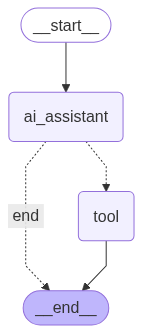

In [136]:
display(Image(app.get_graph().draw_mermaid_png()))

In [138]:
app.invoke({"messages":["who is the upcoming president of usa?"]})

KeyError: 'tools'